In [118]:
# Install required libraries for data analysis and visualization
!pip install fastf1 pandas matplotlib seaborn plotly

In [119]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt

# Enable FastF1 cache
os.makedirs('cache', exist_ok=True)
fastf1.Cache.enable_cache('cache')  # Creates local cache folder if not already present

# Load race session data for the 2023 Belgian Grand Prix
session = fastf1.get_session(2023, 'Belgian Grand Prix', 'R')
session.load()

core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


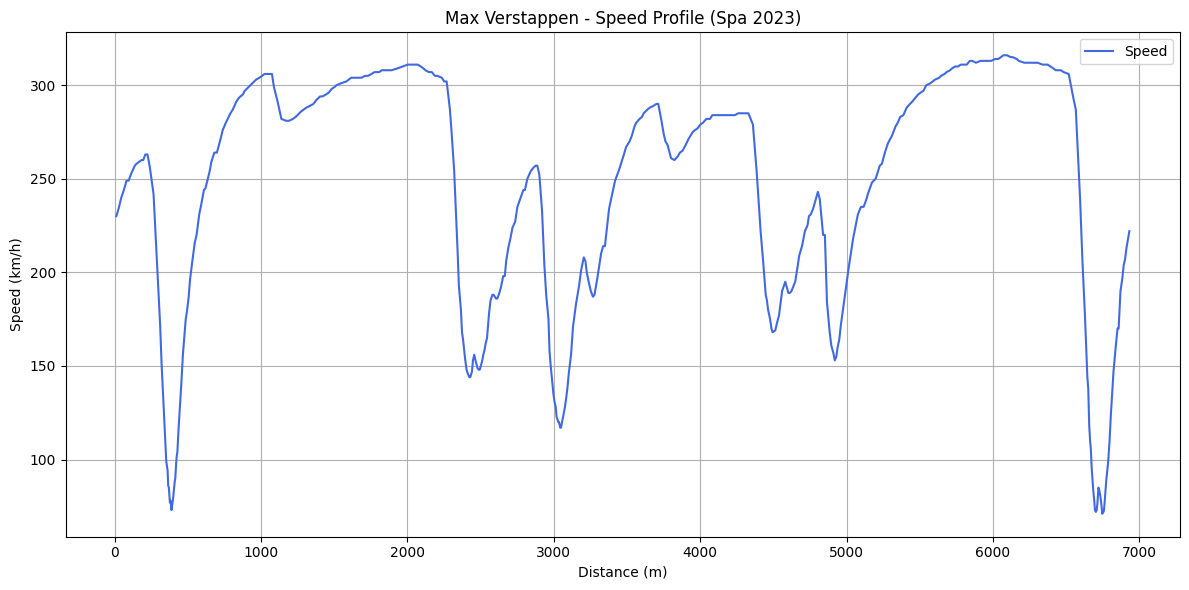

In [120]:
# Extract fastest lap data for Max Verstappen
ver = session.laps.pick_driver('VER').pick_fastest()

# Get telemetry data and add distance column
tel = ver.get_car_data().add_distance()

# Plot speed vs. distance
plt.figure(figsize=(12, 6))
plt.plot(tel['Distance'], tel['Speed'], label='Speed', color='royalblue')
plt.xlabel('Distance (m)')
plt.ylabel('Speed (km/h)')
plt.title('Max Verstappen - Speed Profile (Spa 2023)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
#build a lapset dataset for ML
# Load Spanish Grand prix 2023 race
# Build a lapset dataset for ML
session = fastf1.get_session(2023, 'Spa', 'R')
session.load()

# Pick Verstappen laps
ver_laps = session.laps.pick_driver('VER').pick_accurate()

def summarize_lap(lap):
    tel = lap.get_car_data().add_distance()
    return {
        'LapTime': lap['LapTime'].total_seconds(),
        'AvgSpeed': np.mean(tel['Speed']),
        'MaxSpeed': np.max(tel['Speed']),
        'ThrottlePct': np.mean(tel['Throttle']),
        'BrakePct': np.mean(tel['Brake']),
        'GearChanges': tel['nGear'].diff().abs().sum()
    }

# Apply the function and build the DataFrame
lap_summaries = [summarize_lap(lap) for _, lap in ver_laps.iterrows() if pd.notnull(lap.LapTime)]
df = pd.DataFrame(lap_summaries)  #fixed line

df.head()

events      WARNING 	Correcting user input 'Spa' to 'Spanish Grand Prix'
core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
I

,LapTime,AvgSpeed,MaxSpeed,ThrottlePct,BrakePct,GearChanges
0,80.402,205.931818,297.0,63.808442,0.165584,34.0
1,80.499,208.569620,300.0,64.240506,0.164557,34.0
2,80.346,208.003215,301.0,64.408360,0.157556,32.0
3,80.283,207.085526,302.0,63.730263,0.164474,32.0
4,80.402,206.968051,302.0,63.277955,0.150160,32.0


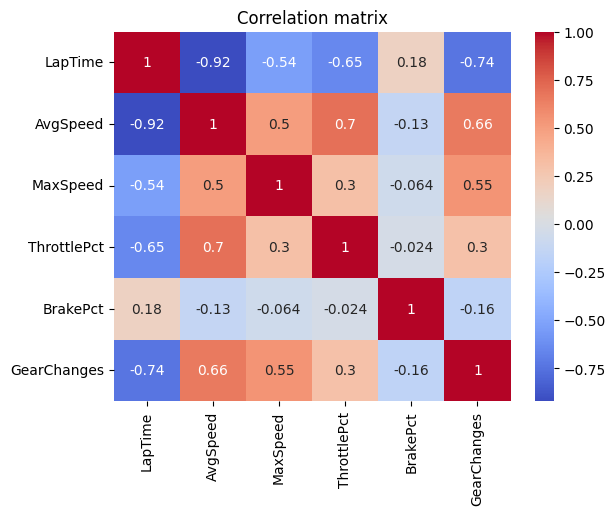

In [122]:
#exploratory data analysis(eda)
import seaborn as sns
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

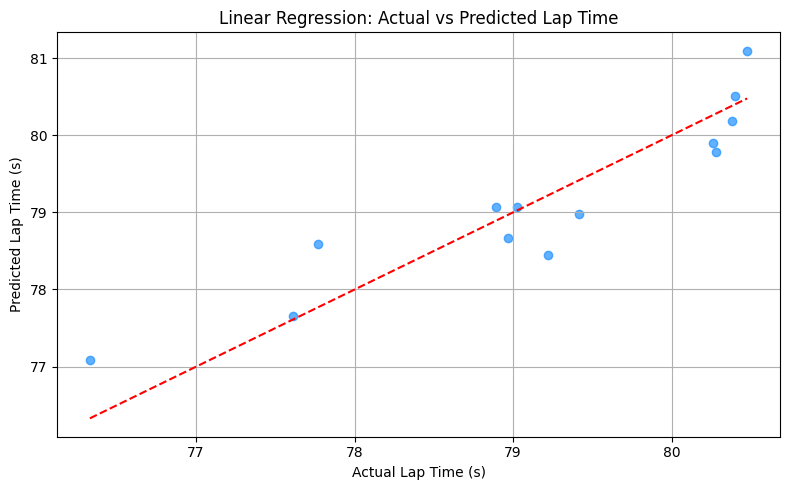

R2 Score: 0.851
MSE: 0.227


In [123]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Prepare features and label
X = df[['AvgSpeed', 'MaxSpeed', 'ThrottlePct', 'BrakePct', 'GearChanges']]
y = df['LapTime']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='dodgerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Linear Regression: Actual vs Predicted Lap Time')
plt.grid(True)
plt.tight_layout()
plt.show()
# Evaluation
print(f"R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")


Random Forest Regressor:
  R2 Score: 0.820
  MSE     : 0.273


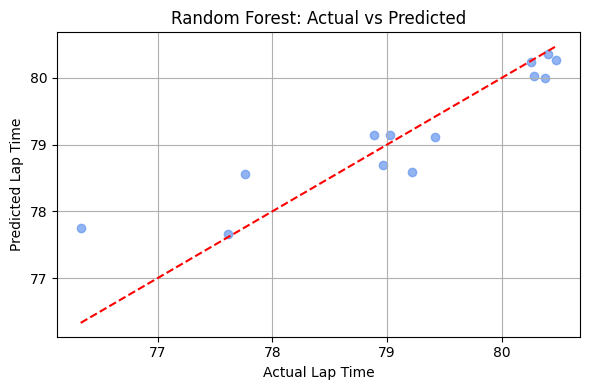

In [124]:
#RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already defined and contains the necessary columns
X = df[['AvgSpeed', 'MaxSpeed', 'ThrottlePct', 'BrakePct', 'GearChanges']]
y = df['LapTime']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Get predictions
y_pred = rf_model.predict(X_test)

# Evaluate
print("Random Forest Regressor:")
print(f"  R2 Score: {r2_score(y_test, y_pred):.3f}")
print(f"  MSE     : {mean_squared_error(y_test, y_pred):.3f}")

# Actual vs Predicted Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.7, color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Lap Time')
plt.ylabel('Predicted Lap Time')
plt.title('Random Forest: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

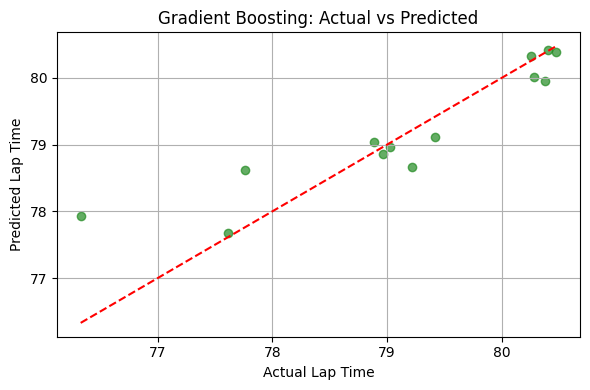

Gradient Boosting Regressor:
  R2 Score: 0.799
  MSE     : 0.306


In [125]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
gbr = GradientBoostingRegressor(random_state=42)
# Train Gradient Boosting
gbr.fit(X_train, y_train)
gbr_preds = gbr.predict(X_test)
# Gradient Boosting
plt.figure(figsize=(6, 4))
plt.scatter(y_test, gbr_preds, alpha=0.7, color='forestgreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Lap Time')
plt.ylabel('Predicted Lap Time')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluate Gradient Boosting
print("Gradient Boosting Regressor:")
print(f"  R2 Score: {r2_score(y_test, gbr_preds):.3f}")
print(f"  MSE     : {mean_squared_error(y_test, gbr_preds):.3f}")


Support Vector Regressor:
  R2 Score: 0.479
  MSE     : 0.792


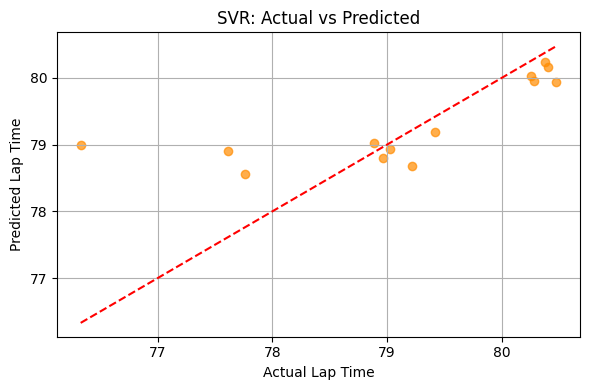

In [126]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Train SVR with scaling
svr = make_pipeline(StandardScaler(), SVR())
svr.fit(X_train, y_train)
svr_preds = svr.predict(X_test)

# Evaluate SVR
print("\nSupport Vector Regressor:")
print(f"  R2 Score: {r2_score(y_test, svr_preds):.3f}")
print(f"  MSE     : {mean_squared_error(y_test, svr_preds):.3f}")

# Plot
plt.figure(figsize=(6, 4))
plt.scatter(y_test, svr_preds, alpha=0.7, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Lap Time')
plt.ylabel('Predicted Lap Time')
plt.title('SVR: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-127-657615730.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')


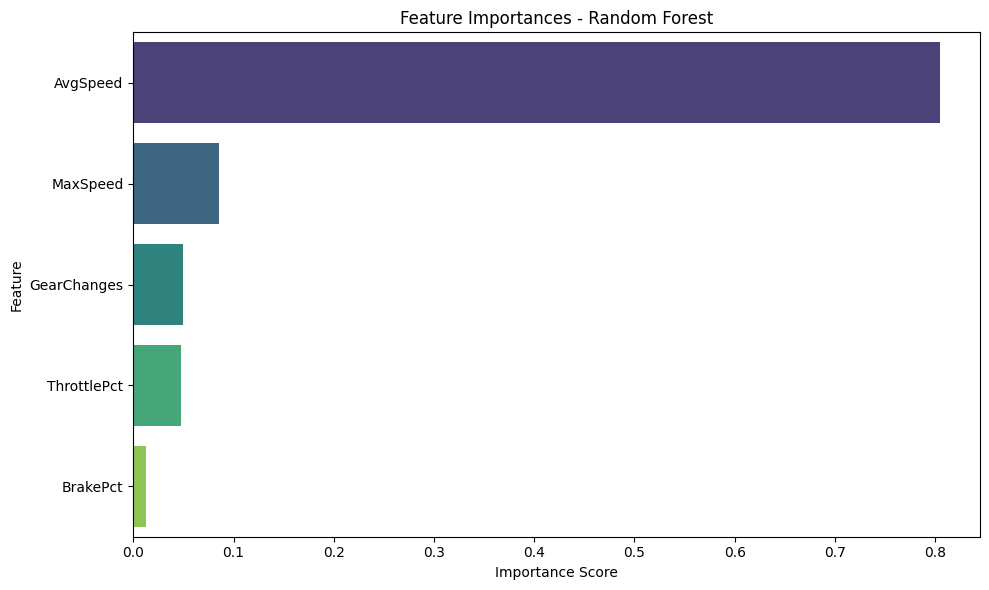

In [127]:
# Get feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for better plotting
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importances - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Among all regression models tested, Linear Regression achieved the highest R² score of 0.85, indicating it best explained the variance in lap time predictions. Surprisingly, it outperformed more complex models like Gradient Boosting regressor (R² ≈ 0.79) and Random Forest (R² ≈ 0.82), suggesting the relationship between features and lap time may be largely linear.

SVR significantly underperformed with an R² score of 0.479, possibly due to default hyperparameters not being optimal for this dataset or its sensitivity to data scale and kernel choice.

Overall, simpler models like Linear Regression proved most effective, highlighting the importance of not overlooking basic models in predictive tasks.



In [128]:
# Extract all laps for Verstappen
laps = session.laps.pick_driver('VER')

feature_rows = []

# Iterate over each lap
for _, lap in laps.iterlaps():
    telemetry = lap.get_car_data().add_distance()

    # Skip if telemetry is missing
    if telemetry.empty:
        continue

    # Calculate speed stats
    avg_speed = telemetry['Speed'].mean()
    max_speed = telemetry['Speed'].max()
    min_speed = telemetry['Speed'].min()

    # Throttle stats
    avg_throttle = telemetry['Throttle'].mean()
    max_throttle = telemetry['Throttle'].max()
    min_throttle = telemetry['Throttle'].min()

    # Brake stats
    avg_brake = telemetry['Brake'].mean()
    brake_time_ratio = telemetry['Brake'].sum() / len(telemetry)

    # Gear stats
    avg_gear = telemetry['nGear'].mean()
    max_gear = telemetry['nGear'].max()

    # Lap time in seconds
    lap_time_sec = lap['LapTime'].total_seconds() if pd.notnull(lap['LapTime']) else np.nan

    # Append all features for this lap
    feature_rows.append({
        'LapNumber': lap['LapNumber'],
        'LapTime': lap_time_sec,
        'AvgSpeed': avg_speed,
        'MaxSpeed': max_speed,
        'MinSpeed': min_speed,
        'AvgThrottle': avg_throttle,
        'MaxThrottle': max_throttle,
        'MinThrottle': min_throttle,
        'AvgBrake': avg_brake,
        'BrakeTimeRatio': brake_time_ratio,
        'AvgGear': avg_gear,
        'MaxGear': max_gear,
    })

# Create DataFrame from feature list
features_df = pd.DataFrame(feature_rows)

# Preview the first few rows
features_df.head()

/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


,LapNumber,LapTime,AvgSpeed,MaxSpeed,MinSpeed,AvgThrottle,MaxThrottle,MinThrottle,AvgBrake,BrakeTimeRatio,AvgGear,MaxGear
0,1.0,83.935,194.481132,284.0,0.0,62.248428,100.0,0.0,0.172956,0.172956,4.801887,7
1,2.0,80.402,205.931818,297.0,97.0,63.808442,100.0,0.0,0.165584,0.165584,5.269481,8
2,3.0,80.499,208.569620,300.0,98.0,64.240506,100.0,0.0,0.164557,0.164557,5.348101,8
3,4.0,80.346,208.003215,301.0,97.0,64.408360,100.0,0.0,0.157556,0.157556,5.311897,8
4,5.0,80.283,207.085526,302.0,97.0,63.730263,100.0,0.0,0.164474,0.164474,5.299342,8


In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

# Set up GridSearchCV
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')

# Fit on training data
grid.fit(X_train, y_train)

# Print best hyperparameters and score
print("Best Params:", grid.best_params_)
print("Best R2 Score (cross-validated):", grid.best_score_)

# Optionally assign best estimator to use for predictions
best_model = grid.best_estimator_

Best Params: {'max_depth': 5, 'n_estimators': 200}
Best R2 Score (cross-validated): 0.8033275799894506
